# Lego Data Exploration

As a longtime Lego fan and peruser of the [Brickset](https://brickset.com/) fansite, I decided to see what interesting trends I could find in their comprehensive database. Over time, my interest in the monetary aspect of Lego has grown: How much do sets cost? Do they cost more nowadays compared to before? Does a given set cost more or less than average? What are the relevant variables for that calculation? (The inescapable question of why Lego is so expensive in general will be ignored, for my sanity.)

Lego also has a thriving secondary market, where certain retired sets [rack in absurd returns](https://www.catawiki.com/stories/715-top-10-most-expensive-lego-sets). My second step, after exploring the above questions, will be to bring in data for current secondary-market prices to build a model to predict which *current* sets might make money in the future. 



In [220]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

%matplotlib inline
plt.rcParams['figure.dpi'] = 216
plt.style.use('fivethirtyeight')

## Preliminary questions
- Are longstanding current themes more likely to have a greater number of set releases per year?
- Has the price per piece increased over time? (Pick a specific theme, e.g. Star Wars)
    - Does this align with inflation? (Pick a specific currency)
- Are some themes more expensive than others? (Pick a specific year range)

In [232]:
curr_themes = ['Architecture', 'Brick Sketches', 'BrickHeadz', 'City', 'Classic', \
               'Collectable Minifigures', 'Creator', 'Creator Expert', 'DC Comics Super Heroes' \
                'Disney', 'DOTS', 'Duplo', 'Education', 'Friends', 'Harry Potter', \
               'Hidden Side', 'Ideas', 'Jurassic World', 'LEGO Art', 'Marvel Super Heroes', \
               'Mindstorms', 'Minecraft', 'Minions: The Rise of Gru', 'Monkie Kid', 'Ninjago' \
               'Overwatch', 'Powered Up', 'Speed Champions', 'Star Wars', 'Super Heroes', \
               'Super Mario', 'Technic ', 'Trolls World Tour']


data = pd.read_csv('allsets.csv')
print('Table has shape:', data.shape)
data.head()

Table has shape: (16806, 24)


,SetID,Number,Variant,ThemeGroup,Theme,SubTheme,Year,Name,Minifigs,Pieces,...,Image,ImageFilename,EAN,UPC,PackagingType,Availability,InstructionsCount,AdditionalImageCount,AgeMin,AgeMax
0,22667,001,1,Vintage themes,Samsonite,Basic Set,1965,Gears,NaN,43.0,...,True,001-1,NaN,NaN,Box,Retail,0,0,5.0,12.0
1,22683,1,3,Vintage themes,Samsonite,Basic Set,1967,Promotional Set No. 1 (Kraft Velveeta),NaN,74.0,...,True,1-3,NaN,NaN,Box,Promotional,0,0,NaN,NaN
2,7465,1,7,Basic,Universal Building Set,NaN,1973,Basic Set,NaN,107.0,...,True,1-7,NaN,NaN,{Not specified},{Not specified},0,0,NaN,NaN
3,7693,1,8,Vintage themes,Minitalia,NaN,1970,Small house set,NaN,67.0,...,True,1-8,NaN,NaN,{Not specified},{Not specified},0,0,NaN,NaN
4,22697,1,9,Basic,System,Basic Set,1969,Set No 1 - Quaker/Life Cereal,NaN,301.0,...,False,NaN,NaN,NaN,Box,{Not specified},0,0,NaN,NaN


## Visualizing numerical values: Year, Minifigs, Pieces, USRetailPrice

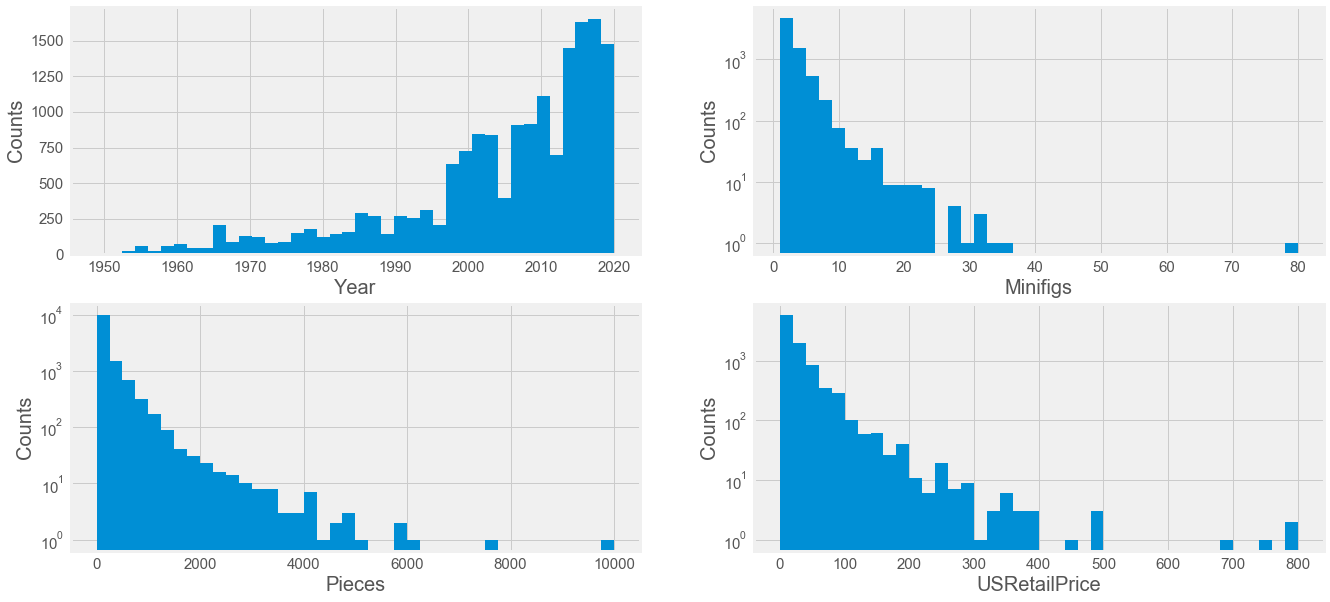

In [233]:
fig, axes = plt.subplots(nrows = 2, ncols = 2)
num_features = ['Year', 'Minifigs', 'Pieces', 'USRetailPrice'] # features of interest
axes = axes.ravel()
for i, ax in enumerate(axes):
    if i == 0:
        ax.hist(data[num_features[i]].dropna(), bins=40)
    else:
        ax.hist(data[num_features[i]].dropna(), bins=40, log=True)
    ax.set_xlabel(num_features[i], fontsize=20)
    ax.set_ylabel('Counts', fontsize=20)
    ax.tick_params(axis='both', labelsize=15)
fig.set_size_inches(20, 10)

A large amount of entries have no pieces (`NaN` or `0`, from looking at the CSV). Either they are not sets (e.g. books, pens, video games, etc.) or the data is incomplete. Regardless, we will discard them.

In [234]:
data = data[~(pd.isna(data['Pieces']) | (data['Pieces']==0))]
print('Table has shape:', data.shape)

Table has shape: (12811, 24)


## Visualizing categorical values: ThemeGroup

Text(0.5, 0, 'Count')

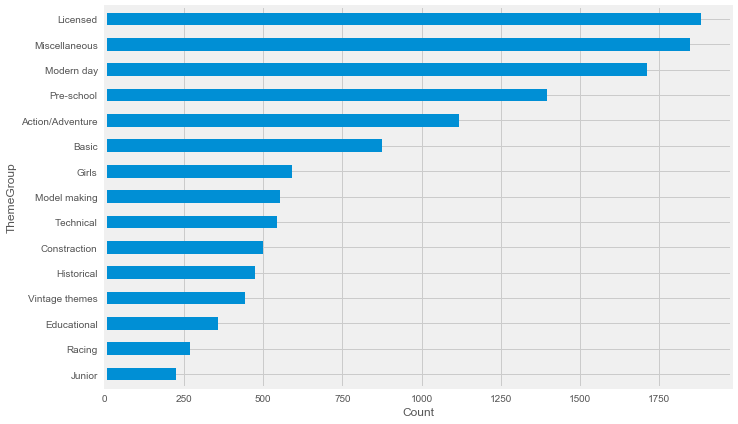

In [235]:
ax = data.groupby('ThemeGroup').size().sort_values().plot(kind='barh', figsize=(10,7))
ax.set_xlabel('Count')

## Are the numerical values correlated?

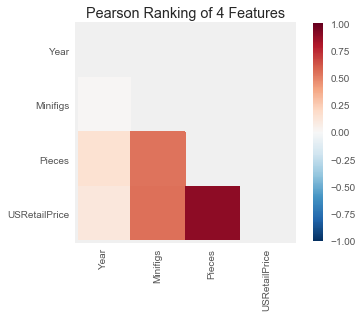

In [236]:
%matplotlib inline

from yellowbrick.features import Rank2D
from yellowbrick.style import set_palette

X = data[num_features].dropna().to_numpy()

visualizer = Rank2D(features=num_features, algorithm='pearson')
visualizer.fit(X)
visualizer.transform(X)
visualizer.show()

A few things of note (that should be prior knowledge for Lego fans!):
- Number of pieces is strongly correlated with price
- Larger, more expensive sets are more likely to have more minifigures

More interestingly, there is a weak trend of sets getting bigger and more expensive over the years. Let's use the data to confirm this hypothesis.

## Has price per piece increased over time?

First, we'll look at the whole dataset. 

Since the first Lego themes were introduced in 1978, we must consider inflation--\\$1 in 1978 is worth more than \\$1 in 2020. Luckily, I found a [CSV file](https://www.in2013dollars.com/us/inflation/1978?amount=1) that lets us account for this.

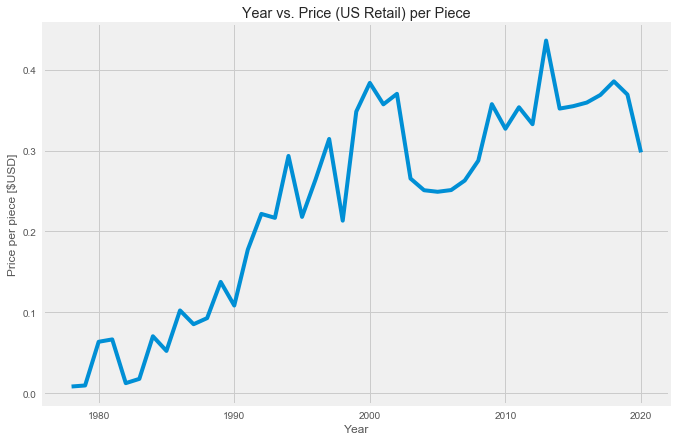

In [237]:
year_list = list(range(1978, 2021)) # The first Lego themes were introduced in 1978
inflation_data = pd.read_csv('inflation_data.csv')

def get_ppp_list_all(): # ppp = price per piece
    ppp_list = []
    for year in year_list:
        year_data = data[data['Year'] == year]
        total_price = year_data['USRetailPrice'].sum(axis='index')
        total_pieces = year_data['Pieces'].sum(axis='index')
        inflation_price = inflation_data[inflation_data['year'] == year]['amount'].iat[0]
        ppp = total_price / total_pieces * inflation_price
        if ppp == 0:
            ppp = np.nan
        ppp_list.append(ppp)        
    return ppp_list

ppp_list = get_ppp_list_all()

plt.figure(figsize=(10,7)) 
plt.xlabel('Year')
plt.ylabel('Price per piece [$USD]')
plt.title('Year vs. Price (US Retail) per Piece')
plt.plot(year_list, ppp_list, label='Average')

The overall trend seems to be increasing. 

But some theme groups, such as Licensed, have a reputation in the Lego community for being more expensive than others. Let's see if this is true.


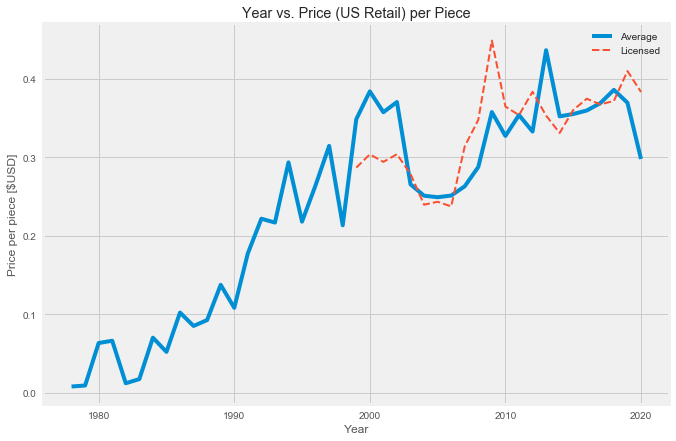

In [238]:
# theme_groups = ['Licensed', 'Miscellaneous', 'Modern day', 'Pre-school', 'Action/Adventure', \
#                 'Basic', 'Girls', 'Model making', 'Technical', 'Constraction', 'Historical', \
#                 'Vintage themes', 'Educational', 'Racing', 'Junior']

def plot_ppp_list(theme): 
    theme_data = data[data['ThemeGroup'] == theme]
    ppp_list = []
    for year in year_list:
        year_data = theme_data[theme_data['Year'] == year] # pandas df version of filter
        total_price = year_data['USRetailPrice'].sum(axis='index') # sum down the column
        total_pieces = year_data['Pieces'].sum(axis='index')
        inflation_price = inflation_data[inflation_data['year'] == year]['amount'].iat[0]
        if total_price == 0 or total_pieces == 0:
            ppp = np.nan
        else:
            ppp = total_price / total_pieces * inflation_price
        ppp_list.append(ppp)        
    plt.plot(year_list, ppp_list, label=theme, linestyle='--', linewidth=2)

plt.figure(figsize=(10,7)) 
plt.xlabel('Year')
plt.ylabel('Price per piece [$USD]')
plt.title('Year vs. Price (US Retail) per Piece')
plt.plot(year_list, ppp_list, label='Average')
plot_ppp_list("Licensed")
plt.legend()


In 1999, the year of their introduction, Licensed sets start off significantly cheaper than average, but grow more expensive in the late 2000's. After 2010 they seem to be par for the course.

Let's plot a few more theme groups to compare.

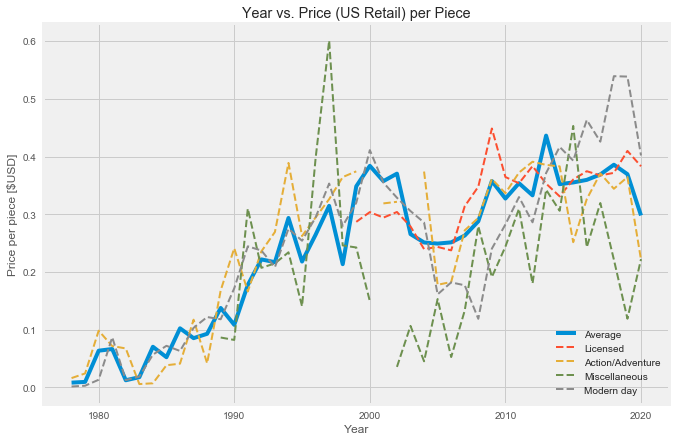

In [239]:
plt.figure(figsize=(10,7)) 
plt.xlabel('Year')
plt.ylabel('Price per piece [$USD]')
plt.title('Year vs. Price (US Retail) per Piece')
plt.plot(year_list, ppp_list, label='Average')
plot_ppp_list("Licensed")
plot_ppp_list("Action/Adventure")
plot_ppp_list("Miscellaneous")
plot_ppp_list("Modern day")
plt.legend()

What's responsible for the spike in Miscellaneous at 1997?

In [229]:
temp = data[(data['ThemeGroup'] == "Miscellaneous") & (data['Year'] == 1997)]
temp[['SetID', 'Theme', 'Year', 'Name', 'Pieces', 'USRetailPrice']]

,SetID,Theme,Year,Name,Pieces,USRetailPrice
1006,3739,Books,1997,Building Ideas Book,1.0,NaN
4378,2413,Service Packs,1997,"Duplo Start / Stop Rail, Single Rail, Change o...",4.0,NaN
4380,2415,Service Packs,1997,"Toolo Loader, Hook and Turntable",3.0,5.5
4554,2596,Service Packs,1997,Angle Bricks Assorted,20.0,4.0
4555,2597,Service Packs,1997,"Angle Beams, Red and Blue",8.0,4.0
4574,2617,Service Packs,1997,Fibre Optic Cables,8.0,3.0
4575,2618,Service Packs,1997,"Technic Beams and Plates with Holes, Black",26.0,4.5
4576,2619,Service Packs,1997,Technic Gear Wheels and Differential Housing,23.0,4.0
4704,2742,Service Packs,1997,Battery Box 9V For Electric System,1.0,5.0
4705,2743,Service Packs,1997,Western Accessories,34.0,5.0


It seems Service Packs are driving up the yearly average. For example, set 2742 (SetID) is a one piece battery that sold for \\$5. 

It isn't really a "set", per se, so given this and similar occurrences, it might be best to exclude the Miscellaneous theme entirely.

In [268]:
data = data[~(data['ThemeGroup'] == 'Miscellaneous')]
print('Table has shape:', data.shape)

Table has shape: (10964, 24)


#### Price prediction using year only

We'll first plot a regression line and see how linear the data is.

In [266]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x = np.array(year_list).reshape((-1,1))
y = ppp_list
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)

r_sq = model.score(x,y)
print('Coefficient of determination r-squared:', r_sq)

Coefficient of determination r-squared: 0.7925355382748327


The $r^{2}$ value is 0.79, which indicates a decent fit to the data. However, the price has been dropping in recent years, and there are peaks and troughs throughout the data. While we can say that the price generally increases in the long run, this simple model would fall short in making short-term predictions.

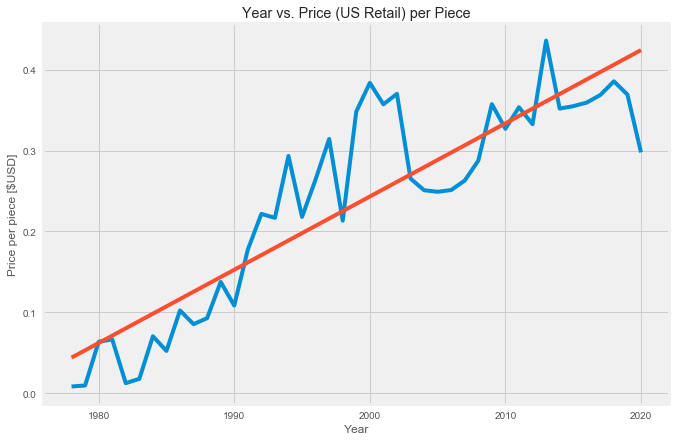

In [272]:
plt.figure(figsize=(10,7)) 
plt.xlabel('Year')
plt.ylabel('Price per piece [$USD]')
plt.title('Year vs. Price (US Retail) per Piece')
plt.plot(year_list, ppp_list, label='Average')
plt.plot(x, y_pred, linewidth=4)